In [1]:
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt

In [2]:
df = web.DataReader('TSLA', data_source='yahoo',start='2012-01-01', end='2022-03-07')
df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2012-01-03,5.900000,5.530000,5.788000,5.616000,4640500.0,5.616000
2012-01-04,5.734000,5.500000,5.642000,5.542000,3150500.0,5.542000
2012-01-05,5.586000,5.370000,5.552000,5.424000,5027500.0,5.424000
2012-01-06,5.558000,5.282000,5.440000,5.382000,4931500.0,5.382000
2012-01-09,5.498000,5.224000,5.400000,5.450000,4485000.0,5.450000
...,...,...,...,...,...,...
2022-03-01,889.880005,853.780029,869.679993,864.369995,24922300.0,864.369995
2022-03-02,886.479980,844.270020,872.130005,879.890015,24881100.0,879.890015
2022-03-03,886.440002,832.599976,878.770020,839.289978,20541200.0,839.289978


In [3]:
data = df.filter(['Close'])
dataset=data.values
training_data_len = math.ceil(len(dataset)*.81)
training_data_len

2075

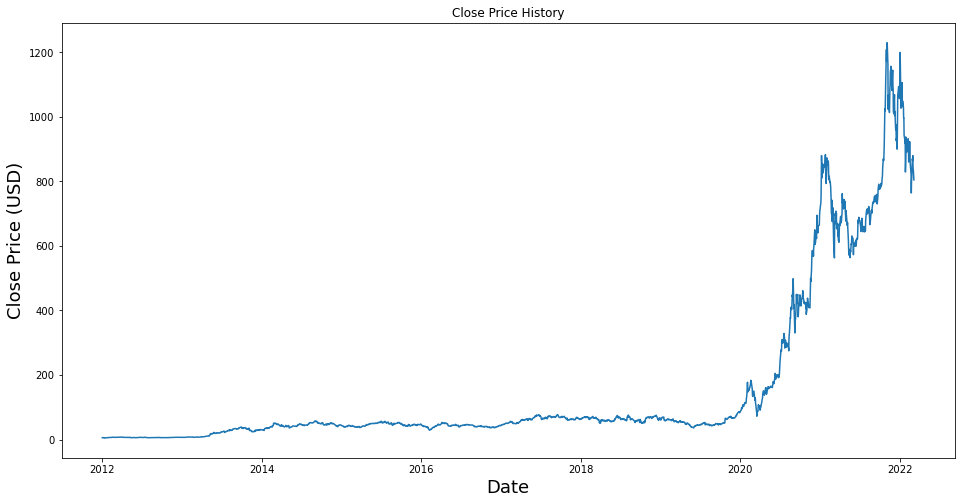

In [4]:
plt.figure(figsize=(16,8))
plt.title('Close Price History')
plt.plot(df['Close'])
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price (USD)',fontsize=18)
plt.show()

In [5]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)
scaled_data

array([[0.00086343],
       [0.00080303],
       [0.00070674],
       ...,
       [0.68121809],
       [0.680402  ],
       [0.65289157]])

In [6]:
train_data = scaled_data[0:training_data_len , :]
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    if i<=60:
        print(x_train)
        print(y_train)
        print()

[array([0.00086343, 0.00080303, 0.00070674, 0.00067246, 0.00072795,
       0.00078834, 0.00088791, 0.00089117, 0.        , 0.00062186,
       0.00065614, 0.00064798, 0.00062186, 0.00064961, 0.0007557 ,
       0.00084547, 0.00100379, 0.00106745, 0.00110662, 0.00102501,
       0.00110825, 0.00121761, 0.00136451, 0.0014706 , 0.00143795,
       0.00149182, 0.00159791, 0.00135634, 0.00142   , 0.00169421,
       0.00176439, 0.00185906, 0.001988  , 0.00191129, 0.00186559,
       0.00191618, 0.00178887, 0.00176766, 0.00179867, 0.00173338,
       0.0018966 , 0.00183621, 0.00179214, 0.00168441, 0.00168605,
       0.00167788, 0.00195046, 0.00215775, 0.0021708 , 0.00204023,
       0.0019929 , 0.00204513, 0.00198963, 0.00198637, 0.00201738,
       0.00189497, 0.00184274, 0.00238462, 0.00247276, 0.00245807])]
[0.0023731955482700017]



In [7]:
x_train,y_train = np.array(x_train), np.array(y_train)

In [8]:
x_train = np.reshape(x_train,(x_train.shape[0],x_train.shape[1], 1))
x_train.shape

(2015, 60, 1)

In [9]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (x_train.shape[1],1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [10]:
model.compile(optimizer='adam',loss='mean_squared_error')

In [11]:
model.fit(x_train, y_train, batch_size=1, epochs=1)

2015/2015 [==============================] - 38s 18ms/step - loss: 4.2102e-05


In [12]:
test_data = scaled_data[training_data_len-60: , :]
x_test=[]
y_test=dataset[training_data_len:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

In [13]:
x_test = np.array(x_test)

In [14]:
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [15]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

In [16]:
rmse = np.sqrt(np.mean(predictions - y_test)**2)
rmse

11.688340756137675

C:\Users\kapoo\AppData\Local\Temp/ipykernel_7304/2133332622.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


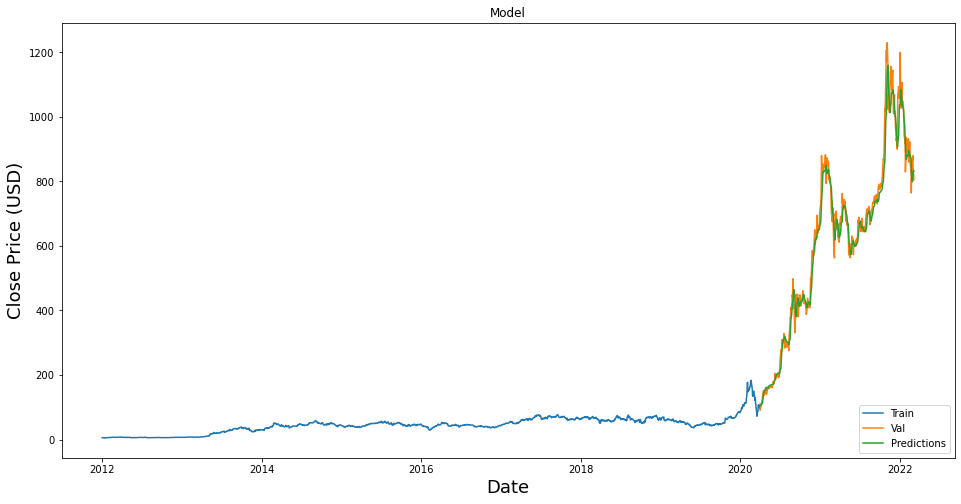

In [17]:
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price (USD)',fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close','Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc ='lower right')
plt.show()

In [18]:
valid

,Close,Predictions
Date,,
2020-04-02,90.893997,109.246384
2020-04-03,96.001999,107.243233
2020-04-06,103.248001,105.762260
2020-04-07,109.089996,106.007683
2020-04-08,109.767998,107.950661
...,...,...
2022-03-01,864.369995,804.367676
2022-03-02,879.890015,814.129333
2022-03-03,839.289978,826.989746


In [19]:
tsla_quote = web.DataReader('TSLA', data_source='yahoo',start='2012-01-01', end='2022-03-07')
new_df = tsla_quote.filter(['Close'])
last_60_days = new_df[-60:].values
last_60_days_scaled = scaler.transform(last_60_days)
X_test=[]
X_test.append(last_60_days_scaled)
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
pred_price = model.predict(X_test)
pred_price = scaler.inverse_transform(pred_price)
print(pred_price)

[[824.28467]]


In [20]:
tsla_quote2 = web.DataReader('TSLA', data_source='yahoo',start='2022-03-01', end='2022-03-07')
print(tsla_quote2['Close'])

Date
2022-02-28    870.429993
2022-03-01    864.369995
2022-03-02    879.890015
2022-03-03    839.289978
2022-03-04    838.289978
2022-03-07    804.580017
Name: Close, dtype: float64
